# LOCAL SEARCH ALGORITHMS

This notebook explores **local search algorithms**, which are particularly useful for solving optimization problems where the path to the goal is irrelevant - only the final state (solution) matters.

## Table of Contents

* [Introduction to Local Search](#Introduction-to-Local-Search)
* [Hill Climbing](#HILL-CLIMBING)
* [Simulated Annealing](#SIMULATED-ANNEALING)
* [Genetic Algorithm](#GENETIC-ALGORITHM)
* [N-Queens Problem](#N-Queens-Problem)

## What is Local Search?

Unlike systematic search algorithms (BFS, DFS, A*) that explore the search space systematically to find a path from an initial state to a goal state, **local search algorithms** operate using a single current state and generally move only to neighbors of that state.

### Key Characteristics of Local Search:

1. **Memory Efficient**: They use very little memory - usually just the current state and possibly some neighboring states
2. **Path Irrelevant**: They don't maintain search trees or paths, focusing only on the current state and its value
3. **Optimization Focus**: They're designed for optimization problems where we want to find the best state according to an objective function
4. **Local Optima**: They can get stuck in local optima - states that are better than their neighbors but not the global best

### When to Use Local Search:

- **Pure optimization problems**: Finding maximum/minimum values (TSP, job scheduling, circuit design)
- **Large or infinite state spaces**: Where systematic search is impractical
- **Satisfactory solutions suffice**: When a good-enough solution is acceptable rather than optimal
- **No path needed**: When only the final configuration matters, not how we got there

### Local Search vs. Systematic Search:

| Aspect | Systematic Search (BFS, A*) | Local Search |
|--------|---------------------------|--------------|
| **Memory** | O(b^d) | O(1) or O(k) |
| **Complete** | Yes (for graph search) | No (can get stuck) |
| **Optimal** | Yes (A* with admissible h) | No (local optima) |
| **Use Case** | Path finding, navigation | Optimization, CSP |
| **State Space** | Must be finite | Can be infinite |

Now let's explore the main local search algorithms!

In [1]:
from search import *
from notebook import psource, pseudocode
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from IPython.display import display, Image
import imgkit
%matplotlib inline

## HILL CLIMBING

Hill Climbing is a heuristic search used for optimization problems.
Given a large set of inputs and a good heuristic function, it tries to find a sufficiently good solution to the problem. 
This solution may or may not be the global optimum.
The algorithm is a variant of generate and test algorithm. 
<br>
As a whole, the algorithm works as follows:
- Evaluate the initial state.
- If it is equal to the goal state, return.
- Find a neighboring state (one which is heuristically similar to the current state)
- Evaluate this state. If it is closer to the goal state than before, replace the initial state with this state and repeat these steps.
<br>

In [2]:
psource(hill_climbing)

We will find an approximate solution to the traveling salespersons problem using this algorithm.
<br>
We need to define a class for this problem.
<br>
`Problem` will be used as a base class.

In [3]:
class TSP_problem(Problem):

    """ subclass of Problem to define various functions """

    def two_opt(self, state):
        """ Neighbour generating function for Traveling Salesman Problem """
        neighbour_state = state[:]
        left = random.randint(0, len(neighbour_state) - 1)
        right = random.randint(0, len(neighbour_state) - 1)
        if left > right:
            left, right = right, left
        neighbour_state[left: right + 1] = reversed(neighbour_state[left: right + 1])
        return neighbour_state

    def actions(self, state):
        """ action that can be excuted in given state """
        return [self.two_opt]

    def result(self, state, action):
        """  result after applying the given action on the given state """
        return action(state)

    def path_cost(self, c, state1, action, state2):
        """ total distance for the Traveling Salesman to be covered if in state2  """
        cost = 0
        for i in range(len(state2) - 1):
            cost += distances[state2[i]][state2[i + 1]]
        cost += distances[state2[0]][state2[-1]]
        return cost

    def value(self, state):
        """ value of path cost given negative for the given state """
        return -1 * self.path_cost(None, None, None, state)

We will use cities from the Romania map as our cities for this problem.
<br>
A list of all cities and a dictionary storing distances between them will be populated.

In [4]:
distances = {}
all_cities = []

for city in romania_map.locations.keys():
    distances[city] = {}
    all_cities.append(city)
    
all_cities.sort()
print(all_cities)

['Arad', 'Bucharest', 'Craiova', 'Drobeta', 'Eforie', 'Fagaras', 'Giurgiu', 'Hirsova', 'Iasi', 'Lugoj', 'Mehadia', 'Neamt', 'Oradea', 'Pitesti', 'Rimnicu', 'Sibiu', 'Timisoara', 'Urziceni', 'Vaslui', 'Zerind']


Next, we need to populate the individual lists inside the dictionary with the manhattan distance between the cities.

In [5]:
import numpy as np
for name_1, coordinates_1 in romania_map.locations.items():
        for name_2, coordinates_2 in romania_map.locations.items():
            distances[name_1][name_2] = np.linalg.norm(
                [coordinates_1[0] - coordinates_2[0], coordinates_1[1] - coordinates_2[1]])
            distances[name_2][name_1] = np.linalg.norm(
                [coordinates_1[0] - coordinates_2[0], coordinates_1[1] - coordinates_2[1]])

The way neighbours are chosen currently isn't suitable for the travelling salespersons problem.
We need a neighboring state that is similar in total path distance to the current state.
<br>
We need to change the function that finds neighbors.

In [6]:
def hill_climbing_tsp(problem):
    
    """From the initial node, keep choosing the neighbor with highest value,
    stopping when no neighbor is better. [Figure 4.2]"""
    
    def find_neighbors(state, number_of_neighbors=100):
        """ finds neighbors using two_opt method """
        
        neighbors = []
        
        for i in range(number_of_neighbors):
            new_state = problem.two_opt(state)
            neighbors.append(Node(new_state))
            state = new_state
            
        return neighbors

    # as this is a stochastic algorithm, we will set a cap on the number of iterations
    iterations = 10000
    current = Node(problem.initial)
    
    while iterations:
        neighbors = find_neighbors(current.state)
        if not neighbors:
            break
        neighbor = argmax_random_tie(neighbors,
                                     key=lambda node: problem.value(node.state))
        if problem.value(neighbor.state) <= problem.value(current.state):
           #Note that it is based on negative path cost method
            current.state = neighbor.state
        iterations -= 1
        
    return current.state

An instance of the TSP_problem class will be created.

In [7]:
tsp = TSP_problem(all_cities)

We can now generate an approximate solution to the problem by calling `hill_climbing`.
The results will vary a bit each time you run it.

In [8]:
hill_climbing_tsp(tsp)

['Drobeta',
 'Giurgiu',
 'Bucharest',
 'Arad',
 'Timisoara',
 'Eforie',
 'Sibiu',
 'Rimnicu',
 'Neamt',
 'Mehadia',
 'Pitesti',
 'Vaslui',
 'Iasi',
 'Urziceni',
 'Zerind',
 'Lugoj',
 'Craiova',
 'Fagaras',
 'Oradea',
 'Hirsova']

The solution looks like this.
It is not difficult to see why this might be a good solution.
<br>
![title](./images/hillclimb-tsp.png)

## SIMULATED ANNEALING

The intuition behind Hill Climbing was developed from the metaphor of climbing up the graph of a function to find its peak. 
There is a fundamental problem in the implementation of the algorithm however.
To find the highest hill, we take one step at a time, always uphill, hoping to find the highest point, 
but if we are unlucky to start from the shoulder of the second-highest hill, there is no way we can find the highest one. 
The algorithm will always converge to the local optimum.
Hill Climbing is also bad at dealing with functions that flatline in certain regions.
If all neighboring states have the same value, we cannot find the global optimum using this algorithm.
<br>
<br>
Let's now look at an algorithm that can deal with these situations.
<br>
Simulated Annealing is quite similar to Hill Climbing, 
but instead of picking the _best_ move every iteration, it picks a _random_ move. 
If this random move brings us closer to the global optimum, it will be accepted, 
but if it doesn't, the algorithm may accept or reject the move based on a probability dictated by the _temperature_. 
When the `temperature` is high, the algorithm is more likely to accept a random move even if it is bad.
At low temperatures, only good moves are accepted, with the occasional exception.
This allows exploration of the state space and prevents the algorithm from getting stuck at the local optimum.


In [9]:
psource(simulated_annealing)

The temperature is gradually decreased over the course of the iteration.
This is done by a scheduling routine.
The current implementation uses exponential decay of temperature, but we can use a different scheduling routine instead.


In [10]:
psource(exp_schedule)

Next, we'll define a peak-finding problem and try to solve it using Simulated Annealing.
Let's define the grid and the initial state first.


In [11]:
initial = (0, 0)
grid = [[3, 7, 2, 8], [5, 2, 9, 1], [5, 3, 3, 1]]

We want to allow only four directions, namely `N`, `S`, `E` and `W`.
Let's use the predefined `directions4` dictionary.

In [12]:
directions4

{'W': (-1, 0), 'N': (0, 1), 'E': (1, 0), 'S': (0, -1)}

Define a problem with these parameters.

In [13]:
problem = PeakFindingProblem(initial, grid, directions4)

We'll run `simulated_annealing` a few times and store the solutions in a set.

In [14]:
solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}

In [15]:
max(solutions)

9

Hence, the maximum value is 9.

In [16]:
from notebook import gaussian_kernel, heatmap

Let's find the peak of a two-dimensional gaussian distribution.
We'll use the `gaussian_kernel` function from notebook.py to get the distribution.

In [17]:
grid = gaussian_kernel()

Let's use the `heatmap` function from notebook.py to plot this.

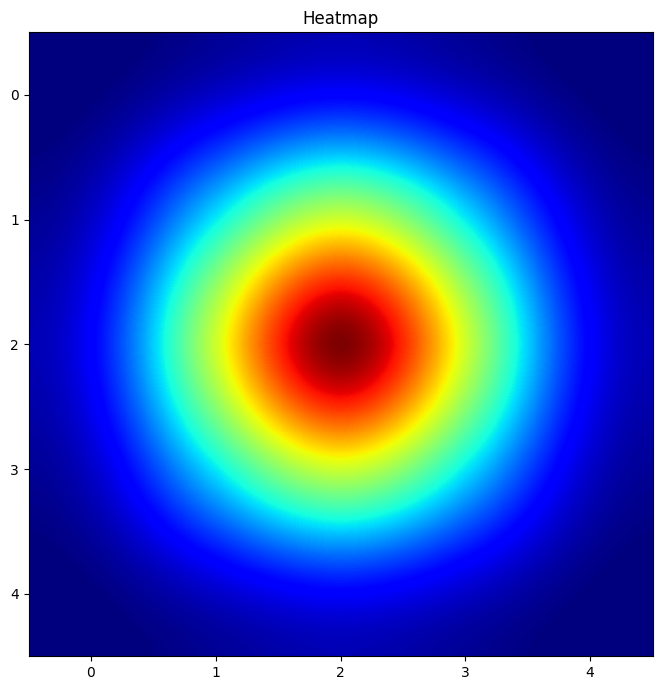

In [18]:
heatmap(grid, cmap='jet', interpolation='spline16')

Let's define the problem.
This time, we will allow movement in eight directions as defined in `directions8`.

In [78]:
directions8

{'W': (-1, 0),
 'N': (0, 1),
 'E': (1, 0),
 'S': (0, -1),
 'NW': (-1, 1),
 'NE': (1, 1),
 'SE': (1, -1),
 'SW': (-1, -1)}

We'll solve the problem just like we did last time.
<br>
Let's also time it.

In [79]:
problem = PeakFindingProblem(initial, grid, directions8)

In [80]:
%%timeit
solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}

52.9 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [81]:
max(solutions)

32

The peak is at 1.0 which is how gaussian distributions are defined.
<br>
This could also be solved by Hill Climbing as follows.

In [23]:
%%timeit
solution = problem.value(hill_climbing(problem))

20.9 μs ± 67.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [24]:
solution = problem.value(hill_climbing(problem))
solution

np.float64(1.0)

As you can see, Hill-Climbing is about 24 times faster than Simulated Annealing.
(Notice that we ran Simulated Annealing for 100 iterations whereas we ran Hill Climbing only once.)
<br>
Simulated Annealing makes up for its tardiness by its ability to be applicable in a larger number of scenarios than Hill Climbing as illustrated by the example below.
<br>

Let's define a 2D surface as a matrix.

In [25]:
grid = [[0, 0, 0, 1, 4], 
        [0, 0, 2, 8, 10], 
        [0, 0, 2, 4, 12], 
        [0, 2, 4, 8, 16], 
        [1, 4, 8, 16, 32]]

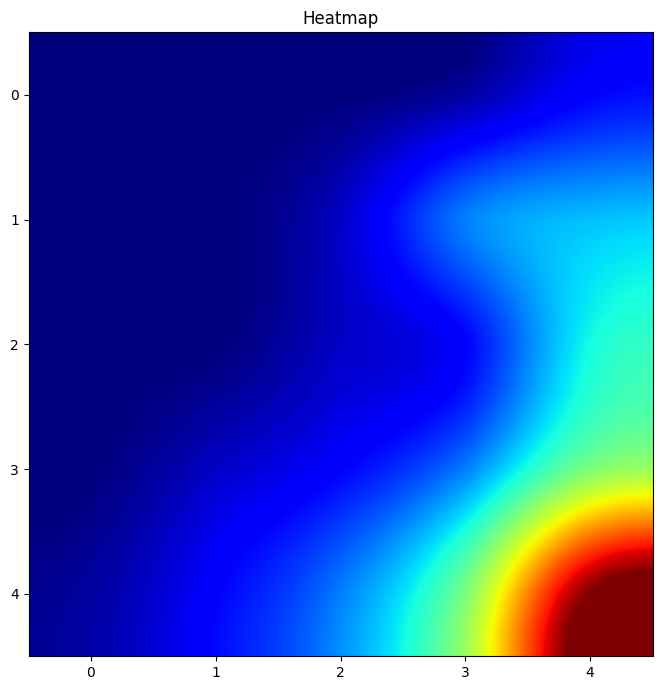

In [26]:
heatmap(grid, cmap='jet', interpolation='spline16')

The peak value is 32 at the lower right corner.
<br>
The region at the upper left corner is planar.

Let's instantiate `PeakFindingProblem` one last time.

In [27]:
problem = PeakFindingProblem(initial, grid, directions8)

Solution by Hill Climbing

In [28]:
solution = problem.value(hill_climbing(problem))

In [29]:
solution

0

Solution by Simulated Annealing

In [30]:
solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}
max(solutions)

32

Notice that even though both algorithms started at the same initial state, 
Hill Climbing could never escape from the planar region and gave a locally optimum solution of **0**,
whereas Simulated Annealing could reach the peak at **32**.
<br>
A very similar situation arises when there are two peaks of different heights.
One should carefully consider the possible search space before choosing the algorithm for the task.

## GENETIC ALGORITHM

Genetic algorithms (or GA) are inspired by natural evolution and are particularly useful in optimization and search problems with large state spaces.

Given a problem, algorithms in the domain make use of a *population* of solutions (also called *states*), where each solution/state represents a feasible solution. At each iteration (often called *generation*), the population gets updated using methods inspired by biology and evolution, like *crossover*, *mutation* and *natural selection*.

### Overview

A genetic algorithm works in the following way:

1) Initialize random population.

2) Calculate population fitness.

3) Select individuals for mating.

4) Mate selected individuals to produce new population.

     * Random chance to mutate individuals.

5) Repeat from step 2) until an individual is fit enough or the maximum number of iterations is reached.

### Glossary

Before we continue, we will lay the basic terminology of the algorithm.

* Individual/State: A list of elements (called *genes*) that represent possible solutions.

* Population: The list of all the individuals/states.

* Gene pool: The alphabet of possible values for an individual's genes.

* Generation/Iteration: The number of times the population will be updated.

* Fitness: An individual's score, calculated by a function specific to the problem.

### Crossover

Two individuals/states can "mate" and produce one child. This offspring bears characteristics from both of its parents. There are many ways we can implement this crossover. Here we will take a look at the most common ones. Most other methods are variations of those below.

* Point Crossover: The crossover occurs around one (or more) point. The parents get "split" at the chosen point or points and then get merged. In the example below we see two parents get split and merged at the 3rd digit, producing the following offspring after the crossover.

![point crossover](./images/point_crossover.png)

* Uniform Crossover: This type of crossover chooses randomly the genes to get merged. Here the genes 1, 2 and 5 were chosen from the first parent, so the genes 3, 4 were added by the second parent.

![uniform crossover](./images/uniform_crossover.png)

### Mutation

When an offspring is produced, there is a chance it will mutate, having one (or more, depending on the implementation) of its genes altered.

For example, let's say the new individual to undergo mutation is "abcde". Randomly we pick to change its third gene to 'z'. The individual now becomes "abzde" and is added to the population.

### Selection

At each iteration, the fittest individuals are picked randomly to mate and produce offsprings. We measure an individual's fitness with a *fitness function*. That function depends on the given problem and it is used to score an individual. Usually the higher the better.

The selection process is this:

1) Individuals are scored by the fitness function.

2) Individuals are picked randomly, according to their score (higher score means higher chance to get picked). Usually the formula to calculate the chance to pick an individual is the following (for population *P* and individual *i*):

$$ chance(i) = \dfrac{fitness(i)}{\sum_{k \, in \, P}{fitness(k)}} $$

### Implementation

Below we look over the implementation of the algorithm in the `search` module.

First the implementation of the main core of the algorithm:

In [31]:
psource(genetic_algorithm)

The algorithm takes the following input:

* `population`: The initial population.

* `fitness_fn`: The problem's fitness function.

* `gene_pool`: The gene pool of the states/individuals. By default 0 and 1.

* `f_thres`: The fitness threshold. If an individual reaches that score, iteration stops. By default 'None', which means the algorithm will not halt until the generations are ran.

* `ngen`: The number of iterations/generations.

* `pmut`: The probability of mutation.

The algorithm gives as output the state with the largest score.

For each generation, the algorithm updates the population. First it calculates the fitnesses of the individuals, then it selects the most fit ones and finally crosses them over to produce offsprings. There is a chance that the offspring will be mutated, given by `pmut`. If at the end of the generation an individual meets the fitness threshold, the algorithm halts and returns that individual.

The function of mating is accomplished by the method `recombine`:

In [32]:
psource(recombine)

The method picks at random a point and merges the parents (`x` and `y`) around it.

The mutation is done in the method `mutate`:

In [33]:
psource(mutate)

We pick a gene in `x` to mutate and a gene from the gene pool to replace it with.

To help initializing the population we have the helper function `init_population`:

In [34]:
psource(init_population)

The function takes as input the number of individuals in the population, the gene pool and the length of each individual/state. It creates individuals with random genes and returns the population when done.

### Explanation

Before we solve problems using the genetic algorithm, we will explain how to intuitively understand the algorithm using a trivial example.

#### Generating Phrases

In this problem, we use a genetic algorithm to generate a particular target phrase from a population of random strings. This is a classic example that helps build intuition about how to use this algorithm in other problems as well. Before we break the problem down, let us try to brute force the solution. Let us say that we want to generate the phrase "genetic algorithm". The phrase is 17 characters long. We can use any character from the 26 lowercase characters and the space character. To generate a random phrase of length 17, each space can be filled in 27 ways. So the total number of possible phrases is

$$ 27^{17} = 2153693963075557766310747 $$

which is a massive number. If we wanted to generate the phrase "Genetic Algorithm", we would also have to include all the 26 uppercase characters into consideration thereby increasing the sample space from 27 characters to 53 characters and the total number of possible phrases then would be

$$ 53^{17} = 205442259656281392806087233013 $$

If we wanted to include punctuations and numerals into the sample space, we would have further complicated an already impossible problem. Hence, brute forcing is not an option. Now we'll apply the genetic algorithm and see how it significantly reduces the search space. We essentially want to *evolve* our population of random strings so that they better approximate the target phrase as the number of generations increase. Genetic algorithms work on the principle of Darwinian Natural Selection according to which, there are three key concepts that need to be in place for evolution to happen. They are:

* **Heredity**: There must be a process in place by which children receive the properties of their parents. <br> 
For this particular problem, two strings from the population will be chosen as parents and will be split at a random index and recombined as described in the `recombine` function to create a child. This child string will then be added to the new generation.


* **Variation**: There must be a variety of traits present in the population or a means with which to introduce variation. <br>If there is no variation in the sample space, we might never reach the global optimum. To ensure that there is enough variation, we can initialize a large population, but this gets computationally expensive as the population gets larger. Hence, we often use another method called mutation. In this method, we randomly change one or more characters of some strings in the population based on a predefined probability value called the mutation rate or mutation probability as described in the `mutate` function. The mutation rate is usually kept quite low. A mutation rate of zero fails to introduce variation in the population and a high mutation rate (say 50%) is as good as a coin flip and the population fails to benefit from the previous recombinations. An optimum balance has to be maintained between population size and mutation rate so as to reduce the computational cost as well as have sufficient variation in the population.


* **Selection**: There must be some mechanism by which some members of the population have the opportunity to be parents and pass down their genetic information and some do not. This is typically referred to as "survival of the fittest". <br>
There has to be some way of determining which phrases in our population have a better chance of eventually evolving into the target phrase. This is done by introducing a fitness function that calculates how close the generated phrase is to the target phrase. The function will simply return a scalar value corresponding to the number of matching characters between the generated phrase and the target phrase.

Before solving the problem, we first need to define our target phrase.

In [35]:
target = 'Genetic Algorithm'

We then need to define our gene pool, i.e the elements which an individual from the population might comprise of. Here, the gene pool contains all uppercase and lowercase letters of the English alphabet and the space character.

In [36]:
# The ASCII values of uppercase characters ranges from 65 to 91
u_case = [chr(x) for x in range(65, 91)]
# The ASCII values of lowercase characters ranges from 97 to 123
l_case = [chr(x) for x in range(97, 123)]

gene_pool = []
gene_pool.extend(u_case) # adds the uppercase list to the gene pool
gene_pool.extend(l_case) # adds the lowercase list to the gene pool
gene_pool.append(' ')    # adds the space character to the gene pool

We now need to define the maximum size of each population. Larger populations have more variation but are computationally more  expensive to run algorithms on.

In [37]:
max_population = 100

As our population is not very large, we can afford to keep a relatively large mutation rate.

In [38]:
mutation_rate = 0.07 # 7%

Great! Now, we need to define the most important metric for the genetic algorithm, i.e the fitness function. This will simply return the number of matching characters between the generated sample and the target phrase.

In [39]:
def fitness_fn(sample):
    # initialize fitness to 0
    fitness = 0
    for i in range(len(sample)):
        # increment fitness by 1 for every matching character
        if sample[i] == target[i]:
            fitness += 1
    return fitness

Before we run our genetic algorithm, we need to initialize a random population. We will use the `init_population` function to do this. We need to pass in the maximum population size, the gene pool and the length of each individual, which in this case will be the same as the length of the target phrase.

In [40]:
population = init_population(max_population, gene_pool, len(target))

We will now define how the individuals in the population should change as the number of generations increases. First, the `select` function will be run on the population to select *two* individuals with high fitness values. These will be the parents which will then be recombined using the `recombine` function to generate the child.

In [41]:
parents = select(2, population, fitness_fn) 

In [42]:
# The recombine function takes two parents as arguments, so we need to unpack the previous variable
child = recombine(*parents)

Next, we need to apply a mutation according to the mutation rate. We call the `mutate` function on the child with the gene pool and mutation rate as the additional arguments.

In [43]:
child = mutate(child, gene_pool, mutation_rate)

The above lines can be condensed into

`child = mutate(recombine(*select(2, population, fitness_fn)), gene_pool, mutation_rate)`

And, we need to do this `for` every individual in the current population to generate the new population.

In [44]:
population = [mutate(recombine(*select(2, population, fitness_fn)), gene_pool, mutation_rate) for i in range(len(population))]

The individual with the highest fitness can then be found using the `max` function.

In [45]:
current_best = max(population, key=fitness_fn)

Let's print this out

In [46]:
print(current_best)

['G', 'e', 'F', 'q', 'k', 'q', 'p', 'c', 'B', 'y', 'A', 'v', 'r', 'w', 'Q', 'h', 'c']


We see that this is a list of characters. This can be converted to a string using the join function

In [47]:
current_best_string = ''.join(current_best)
print(current_best_string)

GeFqkqpcByAvrwQhc


We now need to define the conditions to terminate the algorithm. This can happen in two ways
1. Termination after a predefined number of generations
2. Termination when the fitness of the best individual of the current generation reaches a predefined threshold value.

We define these variables below

In [48]:
ngen = 1200 # maximum number of generations
# we set the threshold fitness equal to the length of the target phrase
# i.e the algorithm only terminates whne it has got all the characters correct 
# or it has completed 'ngen' number of generations
f_thres = len(target)

To generate `ngen` number of generations, we run a `for` loop `ngen` number of times. After each generation, we calculate the fitness of the best individual of the generation and compare it to the value of `f_thres` using the `fitness_threshold` function. After every generation, we print out the best individual of the generation and the corresponding fitness value. Lets now write a function to do this.

In [49]:
def genetic_algorithm_stepwise(population, fitness_fn, gene_pool=[0, 1], f_thres=None, ngen=1200, pmut=0.1):
    for generation in range(ngen):
        population = [mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut) for i in range(len(population))]
        # stores the individual genome with the highest fitness in the current population
        current_best = ''.join(max(population, key=fitness_fn))
        print(f'Current best: {current_best}\t\tGeneration: {str(generation)}\t\tFitness: {fitness_fn(current_best)}\r', end='')
        
        # compare the fitness of the current best individual to f_thres
        fittest_individual = fitness_threshold(fitness_fn, f_thres, population)
        
        # if fitness is greater than or equal to f_thres, we terminate the algorithm
        if fittest_individual:
            return fittest_individual, generation
    return max(population, key=fitness_fn) , generation       

The function defined above is essentially the same as the one defined in `search.py` with the added functionality of printing out the data of each generation.

In [50]:
psource(genetic_algorithm)

We have defined all the required functions and variables. Let's now create a new population and test the function we wrote above.

In [51]:
population = init_population(max_population, gene_pool, len(target))
solution, generations = genetic_algorithm_stepwise(population, fitness_fn, gene_pool, f_thres, ngen, mutation_rate)

The genetic algorithm was able to converge!
We implore you to rerun the above cell and play around with `target, max_population, f_thres, ngen` etc parameters to get a better intuition of how the algorithm works. To summarize, if we can define the problem states in simple array format and if we can create a fitness function to gauge how good or bad our approximate solutions are, there is a high chance that we can get a satisfactory solution using a genetic algorithm. 
- There is also a better GUI version of this program `genetic_algorithm_example.py` in the GUI folder for you to play around with.

### Usage

Below we give two example usages for the genetic algorithm, for a graph coloring problem and the 8 queens problem.

#### Graph Coloring

First we will take on the simpler problem of coloring a small graph with two colors. Before we do anything, let's imagine how a solution might look. First, we have to represent our colors. Say, 'R' for red and 'G' for green. These make up our gene pool. What of the individual solutions though? For that, we will look at our problem. We stated we have a graph. A graph has nodes and edges, and we want to color the nodes. Naturally, we want to store each node's color. If we have four nodes, we can store their colors in a list of genes, one for each node. A possible solution will then look like this: ['R', 'R', 'G', 'R']. In the general case, we will represent each solution with a list of chars ('R' and 'G'), with length the number of nodes.

Next we need to come up with a fitness function that appropriately scores individuals. Again, we will look at the problem definition at hand. We want to color a graph. For a solution to be optimal, no edge should connect two nodes of the same color. How can we use this information to score a solution? A naive (and ineffective) approach would be to count the different colors in the string. So ['R', 'R', 'R', 'R'] has a score of 1 and ['R', 'R', 'G', 'G'] has a score of 2. Why that fitness function is not ideal though? Why, we forgot the information about the edges! The edges are pivotal to the problem and the above function only deals with node colors. We didn't use all the information at hand and ended up with an ineffective answer. How, then, can we use that information to our advantage?

We said that the optimal solution will have all the edges connecting nodes of different color. So, to score a solution we can count how many edges are valid (aka connecting nodes of different color). That is a great fitness function!

Let's jump into solving this problem using the `genetic_algorithm` function.

First we need to represent the graph. Since we mostly need information about edges, we will just store the edges. We will denote edges with capital letters and nodes with integers:

In [52]:
edges = {
    'A': [0, 1],
    'B': [0, 3],
    'C': [1, 2],
    'D': [2, 3]
}

Edge 'A' connects nodes 0 and 1, edge 'B' connects nodes 0 and 3 etc.

We already said our gene pool is 'R' and 'G', so we can jump right into initializing our population. Since we have only four nodes, `state_length` should be 4. For the number of individuals, we will try 8. We can increase this number if we need higher accuracy, but be careful! Larger populations need more computating power and take longer. You need to strike that sweet balance between accuracy and cost (the ultimate dilemma of the programmer!).

In [53]:
population = init_population(8, ['R', 'G'], 4)
print(population)

[['R', 'G', 'G', 'G'], ['R', 'G', 'G', 'R'], ['R', 'G', 'G', 'R'], ['G', 'G', 'G', 'G'], ['R', 'G', 'G', 'G'], ['G', 'G', 'G', 'R'], ['R', 'R', 'R', 'R'], ['G', 'G', 'G', 'R']]


We created and printed the population. You can see that the genes in the individuals are random and there are 8 individuals each with 4 genes.

Next we need to write our fitness function. We previously said we want the function to count how many edges are valid. So, given a coloring/individual `c`, we will do just that:

In [54]:
def fitness(c):
    return sum(c[n1] != c[n2] for (n1, n2) in edges.values())

Great! Now we will run the genetic algorithm and see what solution it gives.

In [55]:
solution = genetic_algorithm(population, fitness, gene_pool=['R', 'G'])
print(solution)

['G', 'R', 'G', 'R']


The algorithm converged to a solution. Let's check its score:

In [56]:
print(fitness(solution))

4


The solution has a score of 4. Which means it is optimal, since we have exactly 4 edges in our graph, meaning all are valid!

*NOTE: Because the algorithm is non-deterministic, there is a chance a different solution is given. It might even be wrong, if we are very unlucky!*

#### Eight Queens

Let's take a look at a more complicated problem.

In the *Eight Queens* problem, we are tasked with placing eight queens on an 8x8 chessboard without any queen threatening the others (aka queens should not be in the same row, column or diagonal). In its general form the problem is defined as placing *N* queens in an NxN chessboard without any conflicts.

First we need to think about the representation of each solution. We can go the naive route of representing the whole chessboard with the queens' placements on it. That is definitely one way to go about it, but for the purpose of this tutorial we will do something different. We have eight queens, so we will have a gene for each of them. The gene pool will be numbers from 0 to 7, for the different columns. The *position* of the gene in the state will denote the row the particular queen is placed in.

For example, we can have the state "03304577". Here the first gene with a value of 0 means "the queen at row 0 is placed at column 0", for the second gene "the queen at row 1 is placed at column 3" and so forth.

We now need to think about the fitness function. On the graph coloring problem we counted the valid edges. The same thought process can be applied here. Instead of edges though, we have positioning between queens. If two queens are not threatening each other, we say they are at a "non-attacking" positioning. We can, therefore, count how many such positionings are there.

Let's dive right in and initialize our population:

In [84]:
population = init_population(100, range(8), 8)
print(population[:5])

[[4, 1, 1, 1, 6, 4, 2, 2], [4, 6, 7, 7, 7, 5, 3, 6], [0, 4, 7, 5, 7, 3, 3, 6], [5, 7, 0, 5, 0, 5, 1, 2], [6, 6, 6, 6, 7, 1, 5, 6]]


We have a population of 100 and each individual has 8 genes. The gene pool is the integers from 0 to 7, in string form. Above you can see the first five individuals.

Next we need to write our fitness function. Remember, queens threaten each other if they are at the same row, column or diagonal.

Since positionings are mutual, we must take care not to count them twice. Therefore for each queen, we will only check for conflicts for the queens after her.

A gene's value in an individual `q` denotes the queen's column, and the position of the gene denotes its row. We can check if the aforementioned values between two genes are the same. We also need to check for diagonals. A queen *a* is in the diagonal of another queen, *b*, if the difference of the rows between them is equal to either their difference in columns (for the diagonal on the right of *a*) or equal to the negative difference of their columns (for the left diagonal of *a*). Below is given the fitness function.

In [85]:
def fitness(q):
    non_attacking = 0
    for row1 in range(len(q)):
        for row2 in range(row1+1, len(q)):
            col1 = int(q[row1])
            col2 = int(q[row2])
            row_diff = row1 - row2
            col_diff = col1 - col2

            if col1 != col2 and row_diff != col_diff and row_diff != -col_diff:
                non_attacking += 1

    return non_attacking

Note that the best score achievable is 28. That is because for each queen we only check for the queens after her. For the first queen we check 7 other queens, for the second queen 6 others and so on. In short, the number of checks we make is the sum 7+6+5+...+1. Which is equal to 7\*(7+1)/2 = 28.

Because it is very hard and will take long to find a perfect solution, we will set the fitness threshold at 25. If we find an individual with a score greater or equal to that, we will halt. Let's see how the genetic algorithm will fare.

In [86]:
solution = genetic_algorithm(population, fitness, f_thres=25, gene_pool=range(8))
print(solution)
print(fitness(solution))

[4, 2, 7, 3, 6, 0, 4, 6]
25


Above you can see the solution and its fitness score, which should be no less than 25.

This is where we conclude Genetic Algorithms.

### N-Queens Problem
Here, we will look at the generalized cae of the Eight Queens problem.
<br>
We are given a `N` x `N` chessboard, with `N` queens, and we need to place them in such a way that no two queens can attack each other.
<br>
We will solve this problem using search algorithms.
To do this, we already have a `NQueensProblem` class in `search.py`.

In [60]:
from notebook import plot_NQueens

In [61]:
psource(NQueensProblem)

In [`csp.ipynb`](https://github.com/aimacode/aima-python/blob/master/csp.ipynb) we have seen that the N-Queens problem can be formulated as a CSP and can be solved by 
the `min_conflicts` algorithm in a way similar to Hill-Climbing. 
Here, we want to solve it using heuristic search algorithms and even some classical search algorithms.
The `NQueensProblem` class derives from the `Problem` class and is implemented in such a way that the search algorithms we already have, can solve it.
<br>
Let's instantiate the class.

In [62]:
nqp = NQueensProblem(8)

Let's use `depth_first_tree_search` first.
<br>
We will also use the %%timeit magic with each algorithm to see how much time they take.

In [63]:
%%timeit
depth_first_tree_search(nqp)

579 μs ± 1.71 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [64]:
dfts = depth_first_tree_search(nqp).solution()

/Users/yanglin/Documents/UCSD/Fall 2025/CSE150B/CSE150B-discussion-agents/notebook.py:1453: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


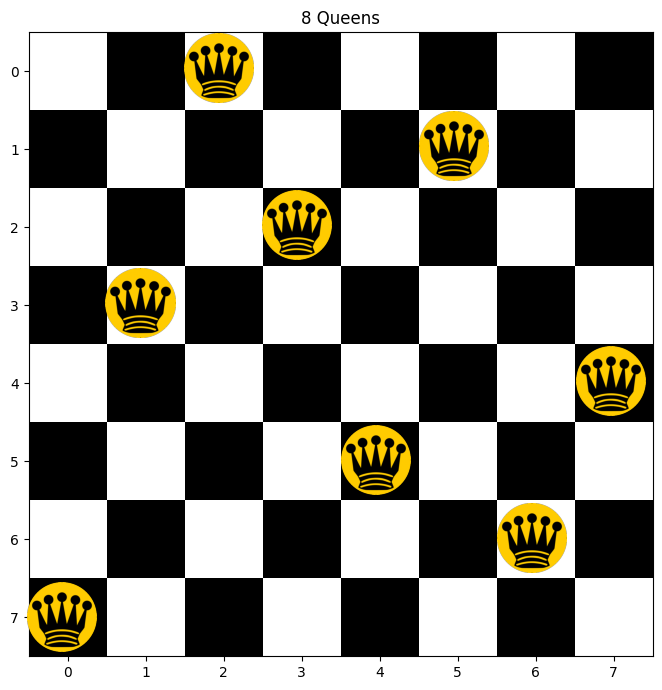

In [65]:
plot_NQueens(dfts)

`breadth_first_tree_search`

In [66]:
%%timeit
breadth_first_tree_search(nqp)

11 ms ± 897 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [67]:
bfts = breadth_first_tree_search(nqp).solution()

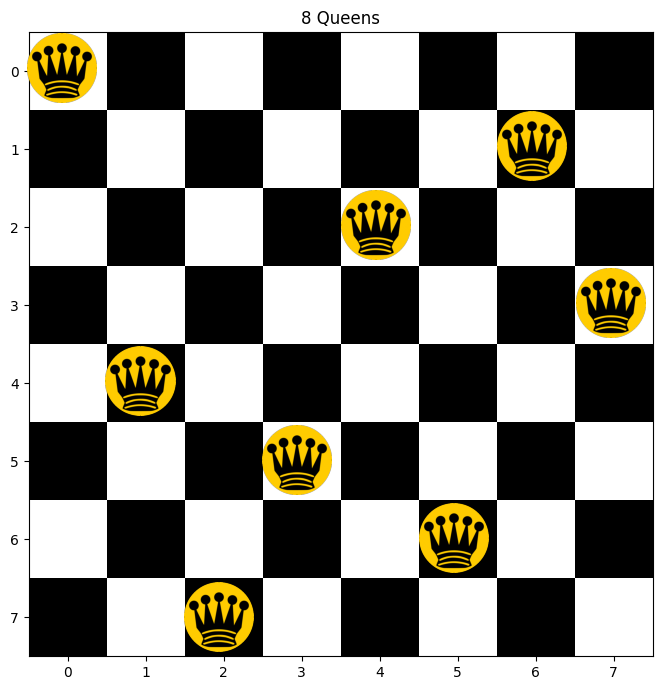

In [68]:
plot_NQueens(bfts)

`uniform_cost_search`

In [69]:
%%timeit
uniform_cost_search(nqp)

74.4 ms ± 706 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [70]:
ucs = uniform_cost_search(nqp).solution()

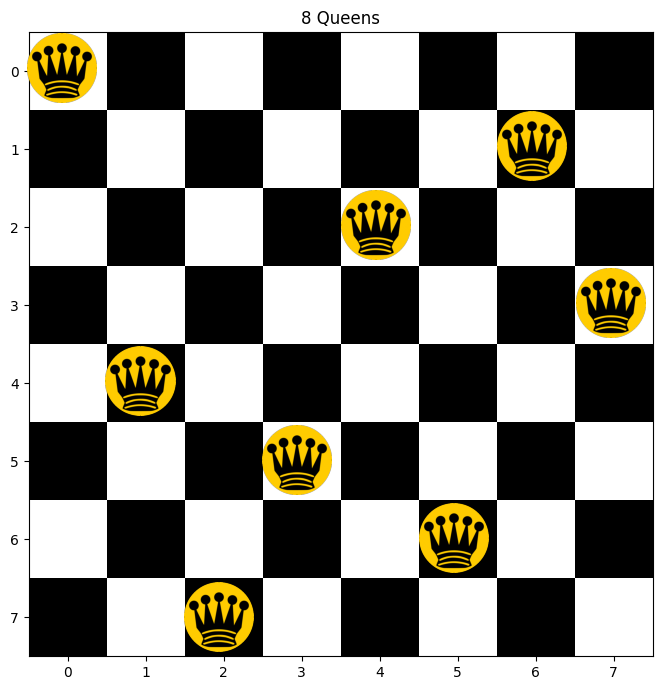

In [71]:
plot_NQueens(ucs)

`depth_first_tree_search` is almost 20 times faster than `breadth_first_tree_search` and more than 200 times faster than `uniform_cost_search`.

We can also solve this problem using `astar_search` with a suitable heuristic function. 
<br>
The best heuristic function for this scenario will be one that returns the number of conflicts in the current state.

In [72]:
psource(NQueensProblem.h)

In [73]:
%%timeit
astar_search(nqp)

990 μs ± 25.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


`astar_search` is faster than both `uniform_cost_search` and `breadth_first_tree_search`.

In [74]:
astar = astar_search(nqp).solution()

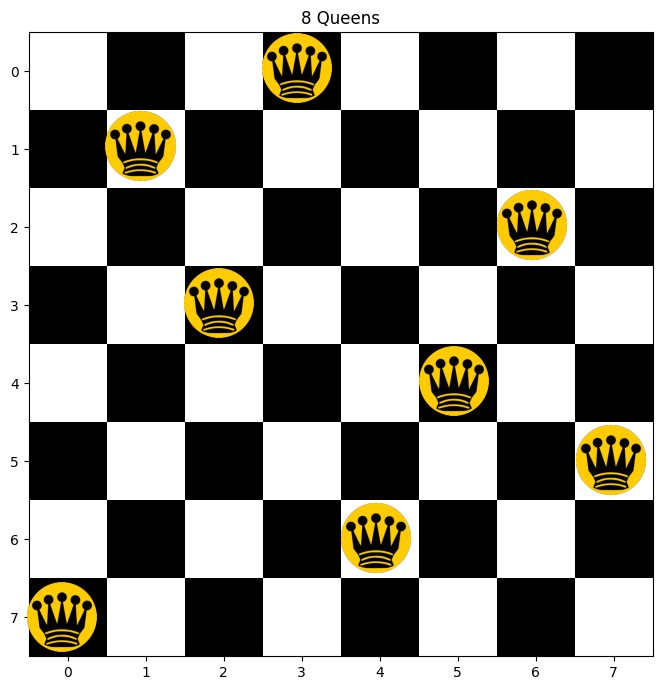

In [75]:
plot_NQueens(astar)

## Summary

In this notebook, we explored the main local search algorithms:

### Hill Climbing
- Simple greedy local search
- Fast but can get stuck in local optima
- Best for smooth landscapes with few local maxima

### Simulated Annealing
- Probabilistic technique inspired by metallurgy
- Escapes local optima by accepting some downhill moves
- Temperature parameter controls exploration vs. exploitation
- More robust than hill climbing but slower

### Genetic Algorithms
- Population-based search inspired by natural evolution
- Uses selection, crossover, and mutation
- Good for complex optimization with large search spaces
- Can maintain diversity and explore multiple regions

### Key Takeaways

1. **Local search trades completeness for efficiency** - they use minimal memory and can handle huge state spaces
2. **Different problems need different algorithms** - smooth landscapes favor hill climbing, rugged landscapes need simulated annealing or genetic algorithms
3. **Randomization helps** - stochastic elements (random restarts, simulated annealing, genetic algorithms) improve robustness
4. **Problem representation matters** - defining good neighbors, value functions, and fitness functions is crucial

### Further Reading

For more details, see:
- Russell & Norvig, *Artificial Intelligence: A Modern Approach*, Chapter 4: Search in Complex Environments
- The `search.py` module for implementation details
- The `csp.ipynb` notebook for constraint satisfaction approaches to N-Queens and similar problems

In [87]:
# Download your notebook, and upload it as agents.ipynb
# Run the code below and download the agents.html file
!jupyter nbconvert --to webpdf localsearch.ipynb

[NbConvertApp] Converting notebook localsearch.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 974076 bytes to localsearch.pdf
